# 2025 YMC
# 신체 지표에 따른 몸무게 예측하기

- 거동이 불가능한 중환자의 경우 정확한 몸무게를 측정하기 어렵습니다.
- 이러한 환자들의 몸무게를 측정할 수 있는 좋은 방법이 없을까요?
- 일반적으로 몸무게가 많이 나가는 사람은 손목, 복부, 발목 등 신체 둘레가 두꺼울 가능성이 높습니다.
- 만약 이러한 신체 지표가 몸무게와 비례 관계가 있다면 직접 측정하지 않아도 몸무게 추정이 가능할 것입니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 불러오기 및 데이터 분석하기

- 데이터를 분석해보면, 몸무게가 많이 나갈 수록 손목 둘레, 복부 둘레, 발목 둘레는 커지기 때문에 몸무게와 각 신체 지표는 비례 관계임을 확인할 수 있습니다.

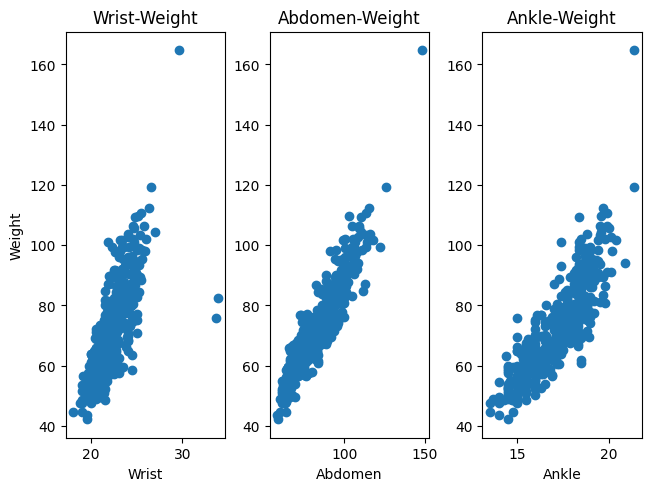

In [2]:
import pandas as pd
# Body Fat Extended Dataset CSV 파일 읽기
csv = pd.read_csv("/content/drive/MyDrive/YMC_2025/YMC_BodyFat/BodyFat.csv")
data = csv.values  # 데이터를 NumPy 배열 형식으로 변환

import matplotlib.pyplot as plt
# 1x3 플롯 생성 (가로로 3개의 서브플롯)
fig, ax = plt.subplots(1, 3, constrained_layout=True)

# 첫 번째 서브플롯: 손목 둘레와 체중의 관계를 산점도로 그리기
ax[0].plot(data[:, 0], data[:, 3], 'o')  # x축: 손목(Wrist), y축: 체중(Weight)
ax[0].set_title("Wrist-Weight")  # 그래프 제목
ax[0].set_xlabel("Wrist")  # x축 라벨
ax[0].set_ylabel("Weight")  # y축 라벨

# 두 번째 서브플롯: 복부 둘레와 체중의 관계를 산점도로 그리기
ax[1].plot(data[:, 1], data[:, 3], 'o')  # x축: 복부(Abdomen), y축: 체중(Weight)
ax[1].set_title("Abdomen-Weight")  # 그래프 제목
ax[1].set_xlabel("Abdomen")  # x축 라벨

# 세 번째 서브플롯: 발목 둘레와 체중의 관계를 산점도로 그리기
ax[2].plot(data[:, 2], data[:, 3], 'o')  # x축: 발목(Ankle), y축: 체중(Weight)
ax[2].set_title("Ankle-Weight")  # 그래프 제목
ax[2].set_xlabel("Ankle")  # x축 라벨

# 그래프 출력
plt.show()

## 2. 훈련(train)데이터, 테스트(test) 데이터 만들기

In [3]:
import numpy as np
# 랜덤 시드 설정 (재현성을 위해 동일한 난수 생성)
np.random.seed(42)
# 데이터 섞기 (shuffle)
np.random.shuffle(data)

# 훈련 데이터(train)와 테스트 데이터(test)로 분리
train_data = data[:400, :]  # 상위 400개 데이터를 훈련 데이터로 사용
test_data = data[400:, :]   # 나머지 데이터를 테스트 데이터로 사용
print("train data shape: ", train_data.shape)  # 훈련 데이터의 모양 출력
print("test data shape: ", test_data.shape)    # 테스트 데이터의 모양 출력

# 훈련 데이터를 입력 데이터(train_X)와 목표 데이터(train_Y)로 분리
train_X = train_data[:, :3] * 0.01  # 첫 3개의 열(특징)을 입력 데이터로 사용, 스케일링(0.01 곱하기)
train_Y = train_data[:, -1:] * 0.01  # 마지막 열(목표값)을 목표 데이터로 사용, 스케일링(0.01 곱하기)
print("train X shape: ", train_X.shape)  # 입력 데이터의 모양 출력
print("train Y shape: ", train_Y.shape)  # 목표 데이터의 모양 출력

train data shape:  (400, 4)
test data shape:  (36, 4)
train X shape:  (400, 3)
train Y shape:  (400, 1)


# 3. 퍼셉트론으로 선형 회귀 문제 풀어보기
- '회귀 분석' 이란 서로 연관 있는 것으로 밝혀진 변수 사이의 관계를 함수 형태인 '회귀 방정식'으로 설정하고, 분석을 통해 회귀 방정식을 명확하게 결정(추정)하는 것입니다.
- 지금까지 배운 퍼셉트론으로 선형 회귀(Linear Regression)를 진행하겠습니다. 아래 퍼셉트론 식을 참고하세요.
$$
    \text{predict}= \text{ReLU}(w_1x_1+w_2x_2+w_3x_3+b)
$$
- 여기서, 하이퍼볼릭 탄젠트가 렐루(ReLU)로 바뀌었음에 유의하세요!
$$
    \text{ReLU} = \begin{cases}
    x& x>0 \\
    0& \text{otherwise}
    \end{cases}
$$
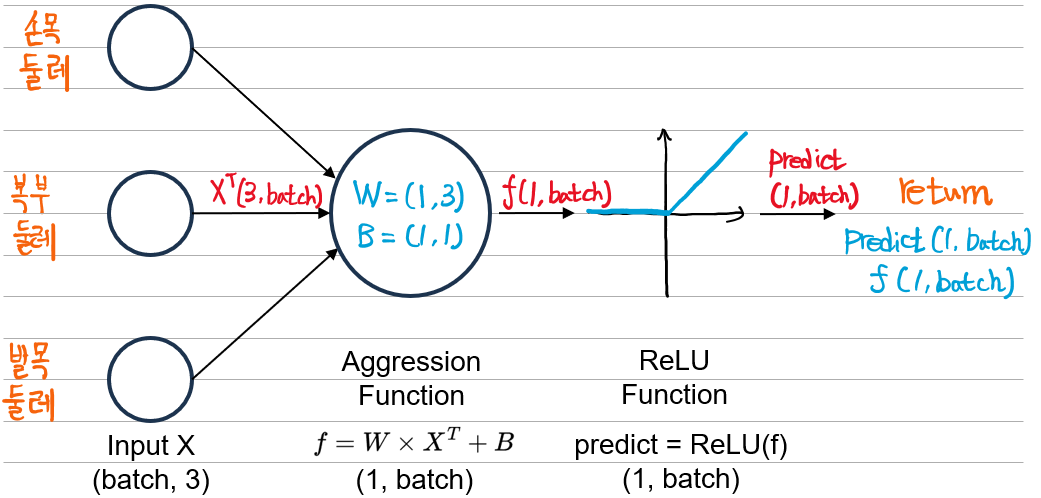


In [4]:
def forward(x, w, b):
    """
    신경망의 순전파(forward) 과정 구현
    x: 입력 데이터 (batch, 3)
    w: 가중치 행렬 (1, 3)
    b: 바이어스 (1, 1)
    """
    # 집계 함수 (행렬 곱 연산)
    f = np.dot(w, np.transpose(x, (1, 0))) + b
    # f의 계산 결과: (1, 3) × (3, batch) + (1, 1) = (1, batch)

    # 출력 함수: ReLU (Rectified Linear Unit)
    predict = np.maximum(0, f)  # 0보다 작은 값을 0으로 변환
    # predict의 크기: (1, batch)

    return predict, f

def loss_function(predict, y):
    """
    손실 함수(Loss Function) 정의
    MSE (Mean Squared Error, 평균 제곱 오차)를 사용
    predict: 예측값 (1, batch)
    y: 실제값 (1, batch)
    """
    return np.mean(np.power(predict - y, 2))  # 예측값과 실제값의 차이를 제곱한 평균

def make_batch(x, y, step, batch_size):
    """
    배치(batch) 생성 함수
    x: 입력 데이터 (전체 샘플, 3)
    y: 목표 데이터 (전체 샘플, 1)
    step: 현재 스텝 (배치의 시작 인덱스)
    batch_size: 배치 크기
    """
    # 배치 크기만큼 데이터를 슬라이싱
    if len(x) > step + batch_size:  # 남은 데이터가 배치 크기보다 많을 경우
        x_batch = x[step : step + batch_size]  # 입력 데이터 배치
        y_batch = y[step : step + batch_size]  # 목표 데이터 배치
    else:  # 남은 데이터가 배치 크기보다 적을 경우
        x_batch = x[step : ]  # 남은 모든 입력 데이터
        y_batch = y[step : ]  # 남은 모든 목표 데이터
    return x_batch, y_batch


## 퍼셉트론 훈련하기

Epoch:  0 Error:  0.03897077678815656
Epoch:  10 Error:  0.007138503775463802
Epoch:  20 Error:  0.006483027743106351
Epoch:  30 Error:  0.005939176888550704
Epoch:  40 Error:  0.005487277009050697
Epoch:  50 Error:  0.005111176458711724
Epoch:  60 Error:  0.004797610300933636
Epoch:  70 Error:  0.004535679489736861
Epoch:  80 Error:  0.004316424494610276
Epoch:  90 Error:  0.004132476196577393
Epoch:  100 Error:  0.003977770010003047
Epoch:  110 Error:  0.003847311741711874
Epoch:  120 Error:  0.003736985790128798
Epoch:  130 Error:  0.0036433979973096112
Epoch:  140 Error:  0.00356374686535023
Epoch:  150 Error:  0.003495717992529019
Epoch:  160 Error:  0.003437397520077915
Epoch:  170 Error:  0.003387201145660234
Epoch:  180 Error:  0.003343815885500923
Epoch:  190 Error:  0.003306152279052376
Epoch:  200 Error:  0.003273305148844348
Epoch:  210 Error:  0.0032445213707331944
Epoch:  220 Error:  0.0032191733900141743
Epoch:  230 Error:  0.0031967374481403684
Epoch:  240 Error:  0.003

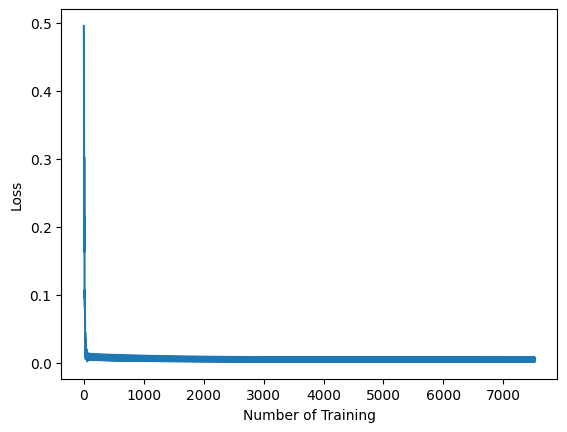

Final loss:  0.004318570150903854


In [5]:
# 가중치와 바이어스를 초기화
W = np.random.randn(1, 3)  # (1, 3) 모양의 가중치 행렬 초기화
B = np.random.randn(1, 1)  # (1, 1) 모양의 바이어스 초기화

# 학습률(learning rate) 및 에폭 수 설정
learning_rate = 1e-03
num_epochs = 300

# 배치 크기 및 손실 저장 리스트 초기화
batch_size = 16
loss_array = []

# 학습 반복 (에폭)
for epoch in range(num_epochs + 1):
    # 매 에폭마다 훈련 데이터를 무작위로 섞기
    np.random.shuffle(train_data)
    steps = 0

    # 배치 학습 수행
    for i in range(int(len(train_X) / batch_size) + 1):
        # 현재 스텝 위치에서 배치 데이터 생성
        X_batch, Y_batch = make_batch(train_X, train_Y, steps, batch_size)

        # 배치 데이터가 비어있다면 중단
        if X_batch.size == 0 or Y_batch.size == 0:
            break

        steps += batch_size  # 다음 배치의 시작점 업데이트

        # 목표 데이터를 (1, batch) 형태로 변환
        Y_batch = np.transpose(Y_batch, (1, 0))

        # 순전파 수행 및 손실 계산
        pred, f = forward(X_batch, W, B)
        Loss = loss_function(pred, Y_batch)
        loss_array.append(Loss)

        # 연쇄법칙을 이용해 기울기 계산
        dL_dpred = 2 * (pred - Y_batch)  # 손실에 대한 예측값의 기울기 (1, batch)
        dpred_df = np.where(pred > 0, 1, 0)  # ReLU 함수의 기울기 (1, batch)
        df_dW = X_batch  # 입력 데이터 (batch, 3)
        dL_df = dL_dpred * dpred_df  # f에 대한 손실의 기울기 (1, batch)

        # 가중치와 바이어스에 대한 손실의 기울기 계산
        dL_dW = np.dot(dL_df, df_dW)  # (1, batch) × (batch, 3) = (1, 3)
        dL_dB = np.sum(dL_df, keepdims=True)  # (1, batch) → (1, 1)

        # 가중치와 바이어스 업데이트
        W = W + -1 * learning_rate * dL_dW
        B = B + -1 * learning_rate * dL_dB

    # 10 에폭마다 손실 출력
    if epoch % 10 == 0:
        print('Epoch: ', epoch, 'Error: ', Loss)

# 학습 손실 시각화
plt.plot(loss_array)
plt.xlabel("Number of Training")  # 학습 횟수
plt.ylabel("Loss")  # 손실 값
plt.show()

# 최종 손실 계산
pred, _ = forward(train_X, W, B)
Loss = loss_function(pred, np.transpose(train_Y, (1, 0)))
print("Final loss: ", Loss)

## 훈련 결과 확인하기

test loss:  0.00357111069062048


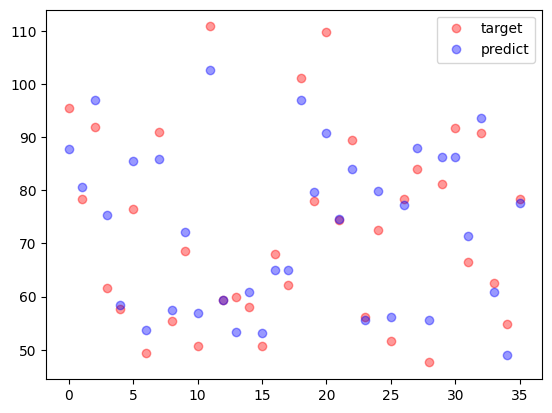

Accuracy with a ±5% error : 47.22222222222222


In [6]:
# 테스트 데이터를 입력(test_X)과 목표(test_Y)로 분리하고 스케일링
test_X = test_data[:, :3] * 0.01  # 첫 3개의 열을 입력 데이터로 사용
test_Y = test_data[:, -1:] * 0.01  # 마지막 열을 목표 데이터로 사용

# 테스트 데이터에 대해 순전파 수행
perceptron_test_pred, _ = forward(test_X, W, B)

# 목표 데이터를 (1, batch) 형태로 변환
test_Y = np.transpose(test_Y, (1, 0))

# 테스트 손실 계산
test_loss = loss_function(perceptron_test_pred, test_Y)
print("test loss: ", test_loss)  # 테스트 데이터에 대한 손실 출력

# 목표값과 예측값 시각화
plt.plot(np.transpose(test_Y * 100, (1, 0)), 'ro', label='target', alpha=0.4)  # 목표값 (빨간 점)
plt.plot(np.transpose(perceptron_test_pred * 100, (1, 0)), 'bo', label='predict', alpha=0.4)  # 예측값 (파란 점)
plt.legend()  # 범례 추가
plt.show()  # 그래프 표시

# 허용 오차(%) 설정
error = 5  # 허용 오차 ±(error)%

# 예측값이 목표값의 허용 범위 내에 있는지 계산
acc = np.logical_and(
    test_Y[0] * (1 - error / 100) <= perceptron_test_pred[0],  # 하한 범위
    test_Y[0] * (1 + error / 100) >= perceptron_test_pred[0]   # 상한 범위
)

# 정확도 계산: 허용 오차 범위 내에 있는 데이터의 비율
perceptron_accuracy = (sum(acc) / len(acc)) * 100
print(f"Accuracy with a ±{error}% error :", perceptron_accuracy)  # 정확도 출력

# 4. 파이토치와 심층신경망으로 선형 회귀 문제 풀어보기

- 파이토치로 은닉층이 2개인 모델을 만들어 선형 회귀 문제를 다시 풀어보겠습니다.
- 데이터셋을 불러오는 과정은 같으므로, 데이터로더를 이용하여 훈련 데이터를 만드는 부분을 수정합니다.

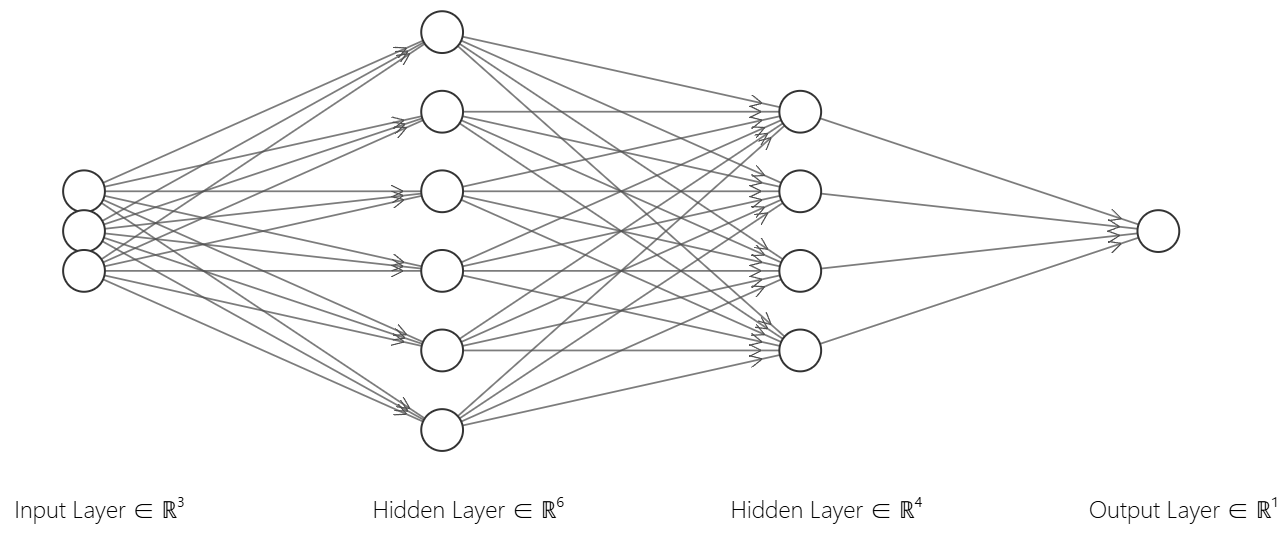

In [7]:
import pandas as pd
import numpy as np

# 데이터 읽기
data = pd.read_csv("/content/drive/MyDrive/YMC_2025/YMC_BodyFat/BodyFat.csv")  # BodyFat 데이터셋 읽기
data = data.values  # 데이터프레임을 Numpy 배열로 변환

# 훈련 데이터(train)와 테스트 데이터(test) 분리
train_data = data[:400, :]  # 첫 400개의 데이터를 훈련 데이터로 사용
test_data = data[400:, :]   # 나머지 데이터를 테스트 데이터로 사용
print("train data shape: ", train_data.shape)  # 훈련 데이터 크기 출력
print("test data shape: ", test_data.shape)    # 테스트 데이터 크기 출력

import torch
from torch.utils.data import TensorDataset, DataLoader

# PyTorch 난수 시드 설정 (결과 재현성 보장)
torch.manual_seed(42)

# 배치 크기 설정
batch_size = 16

# 데이터의 텐서 변환
# 훈련 데이터와 테스트 데이터의 입력(_X), 목표(_Y)를 텐서로 변환
train_X = torch.tensor(train_data[:, :3] * 0.01, dtype=torch.float32)  # 입력 데이터: 스케일링 후 텐서로 변환
train_Y = torch.tensor(train_data[:, -1:] * 0.01, dtype=torch.float32)  # 목표 데이터: 스케일링 후 텐서로 변환
test_X = torch.tensor(test_data[:, :3] * 0.01, dtype=torch.float32)  # 테스트 입력 데이터
test_Y = torch.tensor(test_data[:, -1:] * 0.01, dtype=torch.float32)  # 테스트 목표 데이터

# TensorDataset 생성
# 입력 데이터와 목표 데이터를 묶어 데이터셋 생성
train_dataset = TensorDataset(train_X, train_Y)

# DataLoader 생성
# TensorDataset을 배치 단위로 나누고, 데이터를 무작위로 섞어서 로드
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train data shape:  (400, 4)
test data shape:  (36, 4)


## 모델 정의하기
- 또한, 인공신경망(model)과 최적화(optimizer)를 아래와 같이 수정하였습니다.
- 첫 번재 은닉층의 노드수는 6, 두 번째 은닉층의 노드수는 4입니다.
- 노드수에 정답은 없으며 노드수를 늘리는 것이 성능 향상에 비례하지 않는다는 점을 강조드립니다.
- 또한 확률적 경사 하강법(SGD)대신 Adam이라는 경사하강법 기반 최적화를 선택하였습니다.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# 학습률(learning rate) 및 학습 에폭 수 설정
learning_rate = 0.001  # 경사하강법에서의 학습 속도
num_epochs = 300  # 학습 반복 횟수

# ★ 은닉층이 2개인 인공신경망 모델 정의
model = nn.Sequential(
    nn.Linear(in_features=3, out_features=6, bias=True),  # 입력 뉴런(특징 수 3개) → 은닉층1 (뉴런 6개) + 편향(bias) 포함
    nn.ReLU(),  # 은닉층1 활성화 함수: ReLU
    nn.Linear(in_features=6, out_features=4, bias=True),  # 은닉층1 (뉴런 6개) → 은닉층2 (뉴런 4개) + 편향 포함
    nn.ReLU(),  # 은닉층2 활성화 함수: ReLU
    nn.Linear(in_features=4, out_features=1, bias=True),  # 은닉층2 (뉴런 4개) → 출력층 (뉴런 1개) + 편향 포함
    nn.ReLU()  # 출력층 활성화 함수: ReLU
)

# 최적화 알고리즘 정의
# 경사하강법(Gradient Descent) 기반 Adam 옵티마이저 사용
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## 모델 훈련하기

Epoch : 0 Loss : 0.2777382731437683
Epoch : 10 Loss : 0.004423695616424084
Epoch : 20 Loss : 0.0022166664712131023
Epoch : 30 Loss : 0.0021448165643960238
Epoch : 40 Loss : 0.0029676163103431463
Epoch : 50 Loss : 0.003035444999113679
Epoch : 60 Loss : 0.0013805394992232323
Epoch : 70 Loss : 0.002867070958018303
Epoch : 80 Loss : 0.0019691057968884706
Epoch : 90 Loss : 0.0020939770620316267
Epoch : 100 Loss : 0.0031662327237427235
Epoch : 110 Loss : 0.0032972735352814198
Epoch : 120 Loss : 0.0036446501035243273
Epoch : 130 Loss : 0.001390681485645473
Epoch : 140 Loss : 0.0027542614843696356
Epoch : 150 Loss : 0.0023811166174709797
Epoch : 160 Loss : 0.002693733898922801
Epoch : 170 Loss : 0.0019585497211664915
Epoch : 180 Loss : 0.002240890869870782
Epoch : 190 Loss : 0.002822442911565304
Epoch : 200 Loss : 0.0025110456626862288
Epoch : 210 Loss : 0.0010244729928672314
Epoch : 220 Loss : 0.0025543158408254385
Epoch : 230 Loss : 0.003423333866521716
Epoch : 240 Loss : 0.00361664313822984

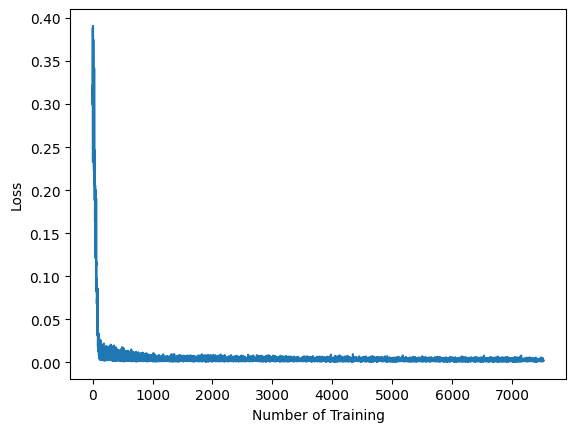

In [9]:
loss_array = []  # 에포크별 손실(loss)을 저장할 리스트

# 학습 루프 시작
for epoch in range(num_epochs + 1):  # 총 num_epochs 만큼 반복

    # 미니배치 단위로 데이터 처리
    for mini_batch in train_loader:  # DataLoader에서 미니배치 로드
        x_batch, y_batch = mini_batch  # 미니배치에서 입력 데이터(x_batch)와 목표 데이터(y_batch) 분리

        # 모델 예측


        ########################################################
        pred =  # 모델을 통해 예측값 계산 -> 채워놓기

        # 손실 함수 계산 (평균 제곱 오차, MSE) -> 채워놓기
        loss =
        ########################################################


        loss_array.append(loss.item())  # 현재 손실 값을 리스트에 저장


        ########################################################
        # 옵티마이저 초기화 (이전 기울기 제거) -> 채워놓기


        # 역전파(Backpropagation)를 통해 기울기 계산 -> 채워놓기


        # 옵티마이저를 통해 파라미터 업데이트 -> 채워놓기

        ########################################################


    # 10 에포크마다 손실 출력
    if epoch % 10 == 0:
        print('Epoch :', epoch, 'Loss :', loss.item())

# 손실 그래프 시각화
plt.plot(loss_array)  # 에포크 진행에 따른 손실 변화 그래프
plt.xlabel("Number of Training")  # x축 레이블: 학습 반복 횟수
plt.ylabel("Loss")  # y축 레이블: 손실 값
plt.show()  # 그래프 출력

## 훈련 결과 분석하기
- 오차율 5%로 했을 때 정확도는 약 66.6%, 오차율 10%일 땐 정확도 약 91.7%로 계산됩니다.
- 넘파이로 구현한 단층 퍼셉트론(오차율 5% 정확도 약 44.4%, 오차율 10% 정확도 약 77.8%)에 비해 성능 향상이 있습니다.

test loss:  0.0015953442780300975


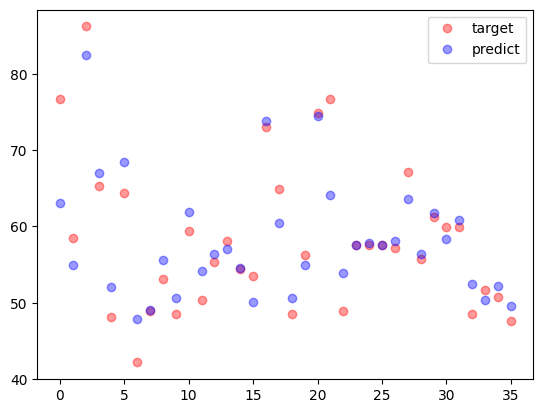

Accuracy with a ±5% error : 66.66666666666666


In [10]:
# 테스트 데이터에 대한 예측
deep_test_pred = model(test_X)  # 모델을 사용하여 테스트 데이터의 예측값 계산
test_loss = F.mse_loss(deep_test_pred, test_Y)  # 테스트 데이터에 대한 평균 제곱 오차(MSE) 손실 계산
print("test loss: ", test_loss.item())  # 테스트 손실 출력

# 텐서 데이터를 NumPy 배열로 변환
# 목표 데이터와 예측값의 차원 변환 (행렬 모양 맞추기)
np_test_Y = np.transpose(test_Y.detach().numpy(), (1, 0))  # (36, 1) → (1, 36)으로 변환
torch_model_test_pred = np.transpose(deep_test_pred.detach().numpy(), (1, 0))  # 예측값 변환

# 목표 데이터와 예측값 비교를 위한 그래프 시각화
plt.plot(np.transpose(np_test_Y * 100, (1, 0)), 'ro', label='target', alpha=0.4)  # 목표 데이터: 빨간 점
plt.plot(np.transpose(torch_model_test_pred * 100, (1, 0)), 'bo', label='predict', alpha=0.4)  # 예측값: 파란 점
plt.legend()  # 범례 추가
plt.show()  # 그래프 출력

# 정확도 분석
# 목표 데이터와 예측값의 오차가 ±error% 범위 내에 있는지 비교
acc = np.logical_and(
    np_test_Y[0] * (1 - error / 100) <= torch_model_test_pred[0],  # 최소 허용값
    np_test_Y[0] * (1 + error / 100) >= torch_model_test_pred[0]   # 최대 허용값
)
# 정확도 계산
deep_accuracy = (sum(acc) / len(acc)) * 100  # 범위 내에 있는 데이터 비율 계산
print(f"Accuracy with a ±{error}% error :", deep_accuracy)  # 정확도 출력


## 퍼셉트론과 뉴럴 네트워크 비교하기